In [1]:
%load_ext autoreload
%autoreload 2

import os, sys, h5py
import pandas as pd, matplotlib.pyplot  as plt, numpy as np

sys.path.append('..')
from utilities.AdjustQ import *
from utilities import model_src as s
from utilities.model import *
from utilities.model_prep import *
from utilities.pixml import *

In [2]:
folder='/home/gwalters/Repo/nwrfc-auto-calibration/runs'
forcing_folder='/home/gwalters/Repo/nwrfc-auto-calibration/data/HDF5_Files'

In [3]:
def get_dataset_keys(path):
    f=h5py.File(path, 'r')
    keys = []
    f.visit(lambda key : keys.append(key) if isinstance(f[key], h5py.Dataset) else None)
    f.close()
    return keys

def hdf_to_df(hdf5, path):

    df=pd.DataFrame(hdf5[path][:])
    date_time=df.columns[0]
    df[date_time]=pd.to_datetime(df[date_time].str.decode('utf-8'))
    df['Source']=df['Source'].str.decode('utf-8')
    df.set_index(date_time,inplace=True)
    return df

def df_to_sarray(df):
    """
    Convert a pandas DataFrame object to a numpy structured array.
    Also, for every column of a str type, convert it into 
    a 'bytes' str literal of length = max(len(col)).

    :param df: the data frame to convert
    :return: a numpy structured array representation of df
    """

    def make_col_type(col_type, col):
        try:
            if 'numpy.object_' in str(col_type.type):
                maxlens = col.dropna().str.len()
                if maxlens.any():
                    maxlen = int(maxlens.max()) 
                    col_type = ('S%s' % maxlen)
                else:
                    col_type = 'f2'
            return col.name, col_type
        except:
            print(col.name, col_type, col_type.type, type(col))
            raise

    v = df.values            
    types = df.dtypes
    numpy_struct_types = [make_col_type(types[col], df.loc[:, col]) for col in df.columns]
    dtype = np.dtype(numpy_struct_types)
    z = np.zeros(v.shape[0], dtype)
    for (i, k) in enumerate(z.dtype.names):
        # This is in case you have problems with the encoding, remove the if branch if not
        try:
            if dtype[i].str.startswith('|S'):
                z[k] = df[k].str.encode('latin').astype('S')
            else:
                z[k] = v[:, i]
        except:
            print(k, v[:, i])
            raise

    return z, dtype

def filter_qin(sf,ts_freq,ts_freq_tol):
    #Grab the nearest instanteous value, within 'ts_freq', to each 'freq_tol' timestep
    inst_q_begin=sf.index[0].floor(freq='D')
    inst_q_end=sf.index[-1].ceil(freq='D')
    inst_q=pd.DataFrame(index=pd.date_range(start=inst_q_begin,end=inst_q_end,freq=ts_freq))
    inst_q.index.rename(sf.index.name,inplace=True)

    #Grab the nearest available the instananeous data within 15 min of the 1hr timesteps
    inst_q=pd.merge_asof(inst_q,sf.iloc[:,0],left_index=True,right_index=True,tolerance=pd.Timedelta(ts_freq_tol),direction='nearest')
    #Remove NA
    inst_q.dropna(axis=0, inplace=True)
    
    return inst_q

def hdf5_check(path,zone=1):
    store=h5py.File(path, 'r')
    keys=pd.Series(get_dataset_keys(path))
    no_zones=list(set(['1','2','3'])-set([str(zone)]))
    keys=keys.loc[(~keys.str.contains('Forcing/Zones'+no_zones[0]))&(~keys.str.contains('Forcing/Zones'+no_zones[-1]))]
    ts_dic=dict()
    for index, value in keys.iteritems():
        #if ('Forcing/Zones'+str(zone) in value) or ('Streamflow' in value):
        try:
            ts_dic[value]=hdf_to_df(store,value)
        except:
            ts_dic[value]=pd.DataFrame(store[value][:])
    store.close()
    return(ts_dic)

In [5]:
run_dir

'/home/gwalters/Repo/nwrfc-auto-calibration/runs/NWWASH/2zone/NRKW1'

<AxesSubplot:>

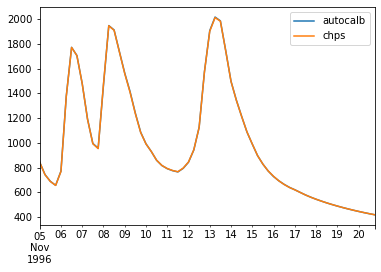

In [30]:
lid='NFNW1'
ac_run='results_por_02'

ac_sim_folder=os.path.join(folder,'NWWASH','2zone')
chps_sim_folder=os.path.join(os.getcwd(),'autocalb_sim_output')

run_dir=os.path.join(ac_sim_folder,lid)
forcing, pars, upflow, flow =nwsrfs_prep(run_dir,ac_run)
sim = Model(forcing,pars,upflow,flow)
ac_sim_run=sim.run_all()

chps_xml=os.path.join(chps_sim_folder,lid+'_SQIN_HS_export.xml')
pixml_file=read_pixml_timeseries(chps_xml)
chps_sim_run=pixml_file.to_df(['units'])
chps_sim_run=chps_sim_run.set_index('valid_datetime').value.astype('float').multiply(35.3147)
chps_sim_run.index=pd.to_datetime(chps_sim_run.index) - pd.DateOffset(hours=6)

compare=pd.concat([ac_sim_run.rename('autocalb'),chps_sim_run.rename('chps')],axis=1)
compare=compare.loc[~compare.isna().any(axis=1)]
compare.loc['11/5/1996':'11/20/1996'].plot()

In [38]:
ac_sim_folder=os.path.join(folder,'NWWASH','2zone')
chps_sim_folder=os.path.join(os.getcwd(),'autocalb_sim_output')


sim_lookup_df=pd.DataFrame({'Fcst_pt':['ARLW1','ARLW1',],
                            'LID':['ARGW1','W1'],
                            'AC_Run':['results_por_02','results_por_03']})

for index, row in sim_lookup_df.iterrows():

    run_dir=os.path.join(ac_sim_folder,row.LID)
    forcing, pars, upflow, flow =nwsrfs_prep(run_dir,row.AC_Run)
    sim = Model(forcing,pars,upflow,flow)
    ac_sim_run=sim.run_all()
    
    chps_xml=os.path.join(chps_sim_folder,row.LID+'_SQIN_HS_export.xml')
    pixml_file=read_pixml_timeseries(chps_xml)
    chps_sim_run=pixml_file.to_df(['units'])
    chps_sim_run=chps_sim_run.set_index('valid_datetime').value.astype('float').multiply(35.3147)
    chps_sim_run.index=pd.to_datetime(chps_sim_run.index) - pd.DateOffset(hours=6)

    new_index=pd.date_range('1979-10-01 00:00:00','2022-10-01 00:00:00',freq='6H')
    sim_run=chps_sim_run.combine_first(ac_sim_run)
    sim_run=sim_run.reindex(new_index)
    sim_run.interpolate(method='linear',limit_direction='both',inplace=True)
    
    store=h5py.File(os.path.join(forcing_folder,row.Fcst_pt+'.h5'), 'a')
    
    obs_daily_mean=hdf_to_df(store, '/Tributary_Streamflow/'+row.LID+'/Daily')

    obs_inst=hdf_to_df(store,'/Tributary_Streamflow/'+row.LID+'/Instantaneous')

    adj_q=pd.DataFrame({'Inst_Streamflow_cfs':adjustq(obs_inst.Inst_Streamflow_cfs,obs_daily_mean.Daily_Avg_Streamflow_cfs,sim_run)})
    adj_q['Source']='Derived'
    adj_q.index=adj_q.index.strftime('%Y-%m-%d %H:%M')
    sa, saType=df_to_sarray(adj_q.reset_index())
    
    adj_q_path = 'Tributary_Streamflow/'+row.LID+'/AdjustQ'   
    if adj_q_path in store:
        del store[adj_q_path]    
    store.create_dataset(adj_q_path, data=sa, dtype=saType, compression="gzip", compression_opts=5)

    store.close()

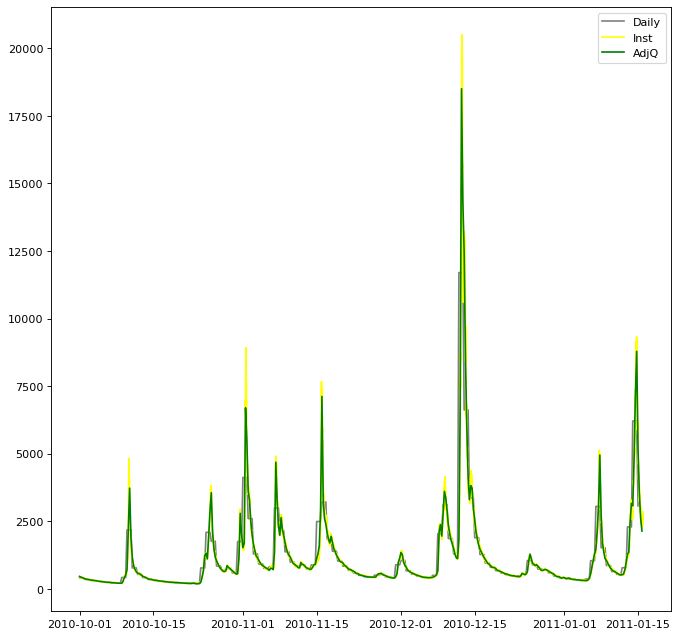

In [8]:
adj_q.index=pd.to_datetime(adj_q.index)

fig, ax = plt.subplots(1,1, dpi= 80, facecolor='w',figsize=(10, 10),sharex=True)

start='Oct 1 2010'
end='Jan 15 2011'

ax.plot(obs_daily_mean.loc[start:end,'Daily_Avg_Streamflow_cfs'].resample('6h').ffill(),color='grey',
       label='Daily')
ax.plot(obs_inst.loc[start:end,'Inst_Streamflow_cfs'],color='yellow',
       label='Inst')
ax.plot(adj_q.loc[start:end,'Inst_Streamflow_cfs'],color='green',label='AdjQ')

ax.legend()